In [1]:
from self_supervised.pipelines.representation_model import RepresentationModel, YoloEncoder
from yolov5.models.yolo import DetectionModel
import torch

%reload_kedro
model_description = catalog.load("yolov5_l_description")
trained_model = catalog.load("trained_model", version="2023-03-23T12.37.00.000Z")

# Random model
# encoder = YoloEncoder(model_description=model_description)
# trained_model = RepresentationModel(encoder=encoder)

# CoCO model
# model_description["head"] = model_description["head"][:-1]
# trained_model = DetectionModel(model_description)
# weights_model = torch.load("../yolov5l.pt", map_location="cpu")
# state_dict = weights_model["model"].float().state_dict()
# trained_model.load_state_dict(state_dict, strict=False)

projection = trained_model.projection
trained_model = trained_model.encoder
trained_model = trained_model.eval()
projection = projection.eval()

2023-03-27 14:13:22,048 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/thop/profile.py:12: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(torch.__version__) < LooseVersion("1.0.0"):

2023-03-27 14:13:22,048 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/thop/profile.py:68: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(torch.__version__) >= LooseVersion("1.1.0"):

2023-03-27 14:13:22,166 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":

2023-03-27 14:13:22,166 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/pyth

2023-03-27 14:13:22.410 | WARNING  | self_supervised.extras.datasets.pytorch_model_data_set:_load:42 - CUDA not available, automatically mapping variables to the CPU.


In [2]:
from pathlib import Path

dataset_path = Path("/home/daniel/lab_share/projects/CottonFlower2021/flower_dataset")

In [3]:
from torchvision.io import read_image
from torchvision.transforms.functional import resize
from tqdm import tqdm
import torch
from typing import Tuple, List
import numpy as np

def extract_image_reps(image_dir_: Path) -> Tuple[List[np.array], List[np.array]]:
    image_reps = []
    image_reps_low_dim = []

    image_list = sorted(list(image_dir_.iterdir()))
    for image_path in tqdm(image_list):
        image = read_image(image_path.as_posix())
        image.requires_grad = False
        image = resize(image, (512, 512))
        image = image.to(torch.float) / 255
        image_ex = image[None, :, :, :]

        image_rep = trained_model(image_ex).detach()
        image_reps.append(image_rep[0].reshape((1, -1)).numpy())
        image_reps_low_dim.append(projection(image_rep)[0].detach().reshape((1, -1)).numpy())
                          
    return image_reps, image_reps_low_dim

In [4]:
# Extract image reps.
_, ground_image_reps_1 = extract_image_reps(dataset_path / "flower01" / "images")
_, ground_image_reps_2 = extract_image_reps(dataset_path / "flower02" / "images")
_, aerial_image_reps_1 = extract_image_reps(dataset_path / "active_1" / "images")
_, aerial_image_reps_2 = extract_image_reps(dataset_path / "2018-08-22" / "images")

100%|████████████████████████████████████████████████████| 160/160 [00:25<00:00,  6.40it/s]


In [10]:
import pandas as pd
from typing import List
import numpy as np

def read_labels(labels_dir: Path, image_reps: List[np.array]) -> List[int]:
    all_labels = []
    labels_list = sorted(list(labels_dir.iterdir()))
    for labels_path in labels_list:
        frame_labels = pd.read_csv(labels_path, sep=" ", names=["class", "x", "y", "width", "height"])
        frame_labels["frame"] = labels_path.name
        all_labels.append(frame_labels)

    all_labels = pd.concat(all_labels, ignore_index=True)
    
    # Create flower counts labels.
    flower_counts = []
    for labels_path in labels_list:
        flower_counts.append(np.count_nonzero(all_labels["frame"] == labels_path.name))

    # Any missing counts are zeros.
    for _ in range(len(flower_counts), len(image_reps)):
        flower_counts.append(0)
        
    return flower_counts

In [11]:
# Extract flower counts.
ground_counts_1 = read_labels(dataset_path / "flower01" / "labels", ground_image_reps_1)
ground_counts_2 = read_labels(dataset_path / "flower02" / "labels", ground_image_reps_2)
aerial_counts_1 = read_labels(dataset_path / "active_1" / "labels", aerial_image_reps_1)
aerial_counts_2 = read_labels(dataset_path / "2018-08-22" / "labels", aerial_image_reps_2)

In [12]:
from sklearn.manifold import TSNE

all_image_reps = ground_image_reps_1 + ground_image_reps_2 + aerial_image_reps_1 + aerial_image_reps_2

# Perform TSNE.
tsne = TSNE()
embedded_reps = tsne.fit_transform(np.concatenate(all_image_reps, axis=0))

In [15]:
all_counts = np.array(ground_counts_1 + ground_counts_2 + aerial_counts_1 + aerial_counts_2)

# Combine embeddings with number of flowers and source data.
platform_type = ["ground" for _ in ground_image_reps_1 + ground_image_reps_2] + ["aerial" for _ in aerial_image_reps_1 + aerial_image_reps_2]
embedded_df = pd.DataFrame(data=dict(x=embedded_reps[:, 0], y=embedded_reps[:, 1], num_flowers=all_counts.astype(int), platform=platform_type))
embedded_df

,x,y,num_flowers,platform
0,9.597203,-36.160416,2,ground
1,9.627851,-36.371716,2,ground
2,9.986639,-36.361328,2,ground
3,9.961180,-36.659893,2,ground
4,10.292375,-36.575184,2,ground
...,...,...,...,...
1106,-22.694836,-7.567948,6,aerial
1107,-27.722752,-9.409860,2,aerial
1108,-25.865850,-22.626467,1,aerial
1109,-22.702257,-20.481615,3,aerial


2023-03-27 14:41:14,215 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":

2023-03-27 14:41:14,218 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)



[Text(0.5, 1.0, 't-SNE Embedding of Validation Datasets')]

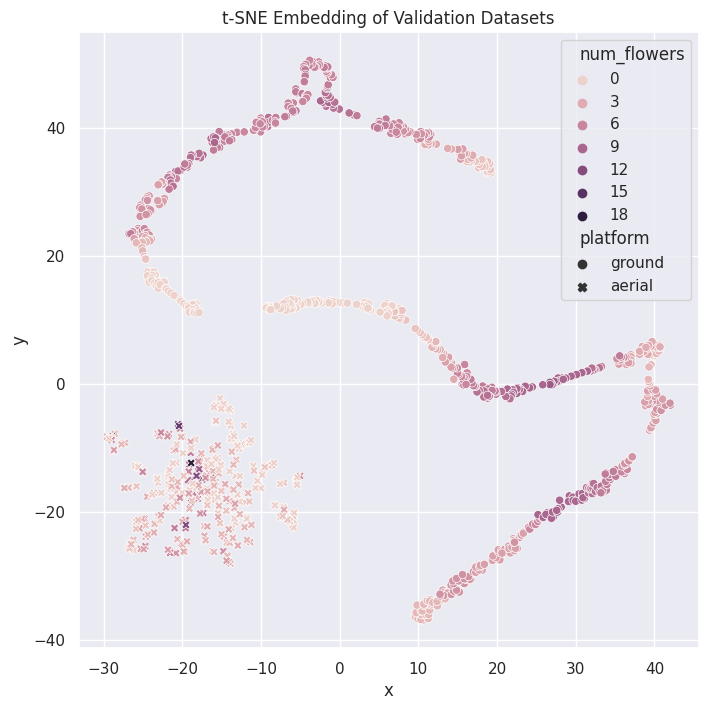

In [24]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={"figure.figsize":(8, 8)})

sns.scatterplot(data=embedded_df, x="x", y="y", hue="num_flowers", style="platform").set(title="t-SNE Embedding of Validation Datasets")

In [26]:
tsne_aerial = TSNE()
aerial_embedded_reps = tsne_aerial.fit_transform(np.concatenate(aerial_image_reps_1 + aerial_image_reps_2, axis=0))

In [27]:
# Combine embeddings with number of flowers and source data.
aerial_embedded_df = pd.DataFrame(data=dict(x=aerial_embedded_reps[:, 0], y=aerial_embedded_reps[:, 1], num_flowers=np.array(aerial_counts_1 + aerial_counts_2).astype(int)))
aerial_embedded_df

,x,y,num_flowers
0,1.159248,7.950544,1
1,3.996256,7.786514,1
2,0.874701,3.785306,8
3,0.961868,2.288509,0
4,9.376358,9.265693,1
...,...,...,...
315,-0.275164,-14.869395,6
316,2.220585,-17.529114,2
317,-14.006283,2.733315,1
318,-8.563890,0.808437,3


[Text(0.5, 1.0, 't-SNE Embedding of Aerial Dataset')]

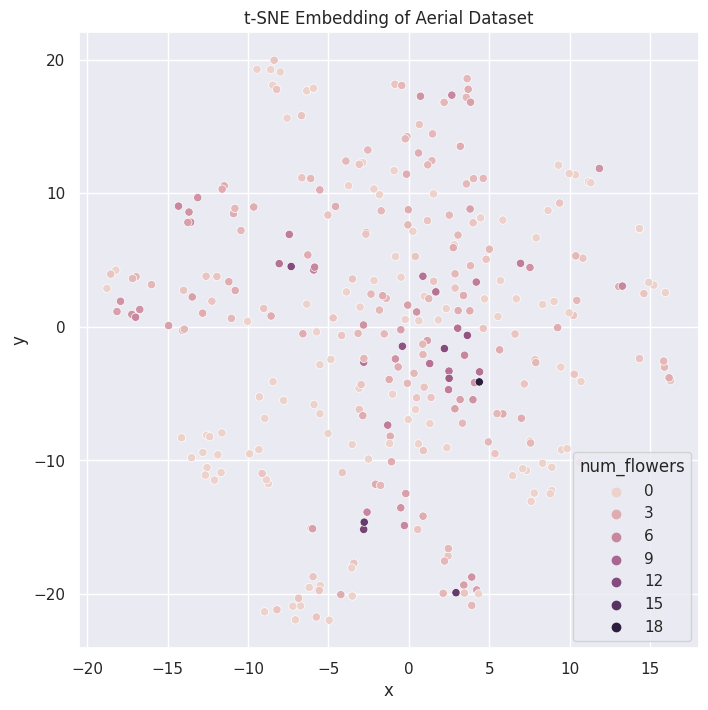

In [28]:
sns.scatterplot(data=aerial_embedded_df, x="x", y="y", hue="num_flowers").set(title="t-SNE Embedding of Aerial Dataset")